<a href="https://colab.research.google.com/github/guilhermegranchopro/Eco-AI.ly/blob/main/Power_Breakdown/Power_Export_Breakdown.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import requests
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, timezone

In [22]:
# Requisição à API
response = requests.get(
    "https://api.electricitymap.org/v3/power-breakdown/history?zone=PT",
    headers={"auth-token": "czG7nq1wv9OHi1phrXUn"}
)
data = response.json()

# Obtém o histórico de dados
historico = data.get("history", [])

In [23]:
def aggregate_export(history, time_hours, now):
    """
    Agrega os valores da chave 'powerExportBreakdown' e o campo 'powerExportTotal'
    para os registros que se encontram no intervalo de 'time_hours' até 'now'.

    Retorna:
      - Um dicionário com a soma dos valores para cada chave de exportação (breakdown);
      - O total agregado de 'powerExportTotal';
      - O timestamp limite.
    """
    limite = now - timedelta(hours=time_hours)
    export_breakdown_total = {}
    export_total_sum = 0
    for registro in history:
        dt_str = registro.get("datetime")
        if not dt_str:
            continue
        # Converte o timestamp para um objeto datetime aware (UTC)
        dt = datetime.fromisoformat(dt_str.replace("Z", "+00:00"))
        if dt < limite or dt > now:
            continue

        export_breakdown = registro.get("powerExportBreakdown", {})
        for key, val in export_breakdown.items():
            if val is None:
                val = 0
            export_breakdown_total[key] = export_breakdown_total.get(key, 0) + val

        # Agrega o total
        val_total = registro.get("powerExportTotal", 0)
        if val_total is None:
            val_total = 0
        export_total_sum += val_total

    return export_breakdown_total, export_total_sum, limite

In [24]:
def format_label(label):
    """
    Retorna o label formatado: se estiver todo em maiúsculas, mantém;
    caso contrário, capitaliza a primeira letra.
    """
    return label if label.isupper() else label.capitalize()

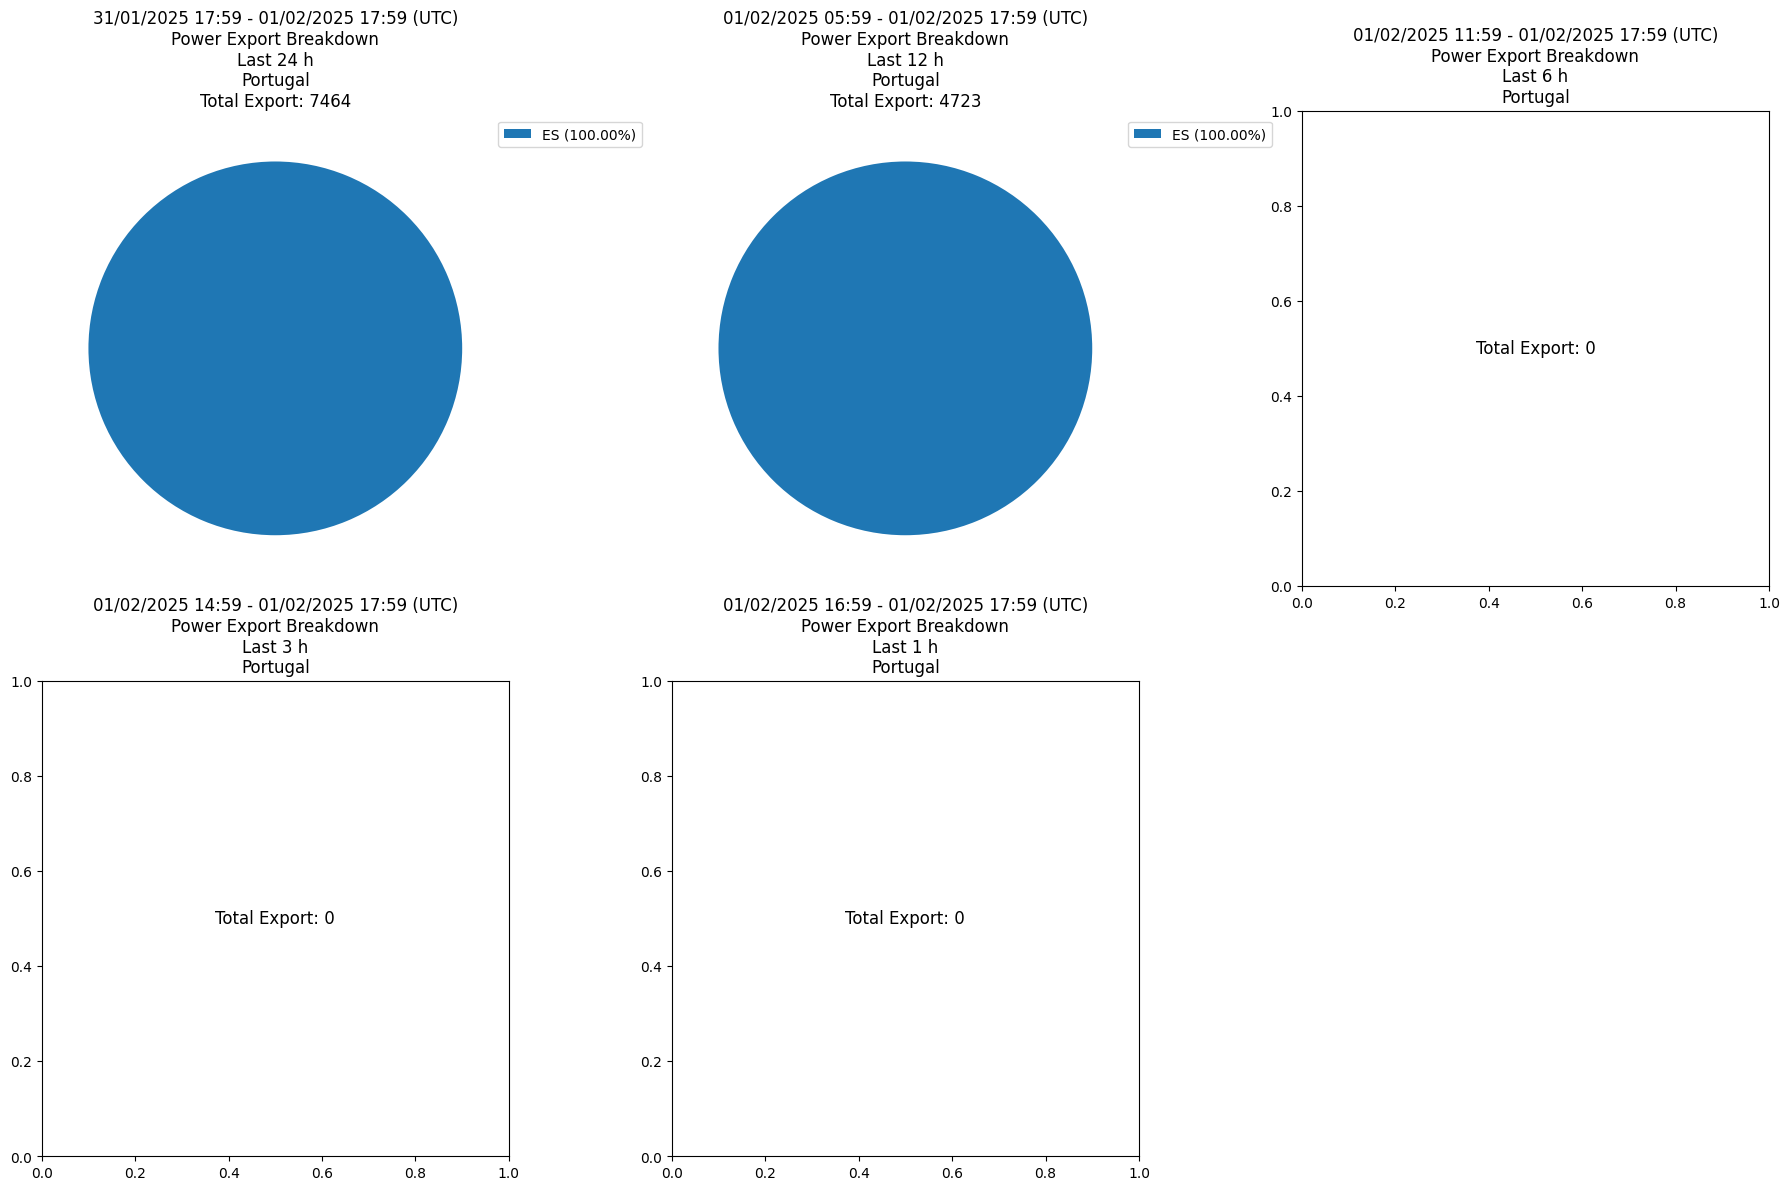

In [30]:
# Define os intervalos desejados (em horas)
time_frames = [24, 12, 6, 3, 1]
now = datetime.now(timezone.utc)

# Cria uma figura com subplots: 2 linhas x 3 colunas (6 subplots, usaremos 5)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, horas in enumerate(time_frames):
    export_breakdown_total, export_total_sum, limite = aggregate_export(historico, horas, now)

    # Formata a string do time frame para o título
    timeframe_str = f"{limite.strftime('%d/%m/%Y %H:%M')} - {now.strftime('%d/%m/%Y %H:%M')} (UTC)"

    # Caso o powerExportTotal seja zero, exibe uma mensagem no gráfico e pula para o próximo
    if export_total_sum == 0:
        axes[i].text(0.5, 0.5, "Total Export: 0",
                     horizontalalignment="center", verticalalignment="center", fontsize=12)
        axes[i].set_title(f"{timeframe_str}\nPower Export Breakdown\nLast {horas} h\nPortugal")
        continue

    # Prepara os dados para o gráfico de pizza: ignora valores negativos e itens com total zero
    labels = []
    valores = []
    for key, total in export_breakdown_total.items():
        total = max(total, 0)
        if total != 0:
            labels.append(format_label(key))
            valores.append(total)

    if valores:
        soma_total = sum(valores)
        # Cria o gráfico de pizza sem rótulos internos
        wedges, _ = axes[i].pie(valores, startangle=90)

        # Combina labels, valores e wedges, ordenando em ordem decrescente pelo valor
        items = list(zip(labels, valores, wedges))
        items_sorted = sorted(items, key=lambda x: x[1], reverse=True)
        labels_sorted = [f"{lab} ({(val/soma_total*100):.2f}%)" for lab, val, _ in items_sorted]
        wedges_sorted = [w for _, _, w in items_sorted]

        axes[i].set_title(f"{timeframe_str}\nPower Export Breakdown\nLast {horas} h\nPortugal\nTotal Export: {export_total_sum}")
        axes[i].legend(wedges_sorted, labels_sorted,
                       loc="upper right", bbox_to_anchor=(1.3, 1))
    else:
        axes[i].text(0.5, 0.5, f"Sem dados para as últimas {horas} horas",
                     horizontalalignment="center", verticalalignment="center")
        axes[i].set_title(f"Power Export Breakdown\nÚltimas {horas} horas\nTotal Export: {export_total_sum}")

# Desativa o subplot extra, se houver
if len(axes) > len(time_frames):
    axes[-1].axis("off")

plt.tight_layout()
plt.show()